# Лабораторная работа #3. Методы высокого порядка
**Выполнили**: Бессонницын Евгений (M32341), Фадеев Олег (M32351)


In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import numpy.linalg as ln
import collections

In [2]:
style.use('seaborn-white')

# Задание 1
## Гаусс-Ньютон — реализация

In [3]:
def with_sinus(X, B):
    return (B[0] + B[1] * X) / (X**2 + B[1]) + np.sin(X) * B[0]


def parabola(X, B):
    return B[0] * X ** 2 + B[1] * X


def linear(X, B):
   return B[0] + X * B[1]

In [4]:
class Nonlinear_regression_solver:
    def __init__(self, function, eps, max_iterations):
        self.function = function
        self.eps = eps
        self.max_iterations = max_iterations
        self.X = None
        self.Y = None
        self.B = None

    def fit(self, X, Y, B):
        pass

    def run(self, N = 30, rand_coefficient = 2):
        X, B, Y = self.generate_starting_values(N, rand_coefficient)
        B0 = [0, 0]
        Bf, count_of_iterations = self.fit(X, Y, B0)
        Xg = np.linspace(1, N * 0.5, 500)
        self.paint(B, Bf, X, Xg, Y, count_of_iterations)

    def generate_starting_values(self, N, rand_coefficient):
        X = np.linspace(1, N * 0.5, N)
        B = np.random.randint(5, size=2) + 1
        Y = self.function(X, B) + rand_coefficient * np.random.rand(N)
        return X, B, Y

    def paint(self, B, Bf, X, Xg, Y, count_of_iterations):
        print(f"Запуск на функции     {self.function}")
        print(f"Действительный B:               {B}")
        plt.plot(Xg, self.function(Xg, B), color='blue', label='Без шумов')
        print(f"Найденные коэфициенты:    {Bf}")
        print()
        fig = plt.figure(1, figsize=(6, 4), dpi=120)
        fig.set_size_inches(13, 8)
        plt.scatter(X, Y, color='red')
        plt.plot(Xg, self.function(Xg, Bf), color='green', label='ожидаемое')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"Количество итераций: {count_of_iterations}")
        plt.legend()
        plt.show()

In [5]:
class GaussNewton(Nonlinear_regression_solver):
    def __init__(self, function, eps, max_iterations):
        super().__init__(function, eps, max_iterations)

    def fit(self, X, Y, B):
        self.X = X
        self.Y = Y
        self.B = B

        error_prev = np.inf
        final_iterations = 0
        for iteration in range(self.max_iterations):
            residual = self.calculate_residual(self.B)
            J = self.calculate_jacobian(self.B)
            self.B -= self.inverse(J) @ residual

            error = np.sqrt(np.sum(residual**2))
            error_diff = np.abs(error_prev - error)
            final_iterations = iteration
            if error_diff < self.eps:
                return self.B, final_iterations
            error_prev = error

        return self.B, final_iterations

    def calculate_residual(self, B):
        Y_cur = self.function(self.X, B)
        return Y_cur - self.Y

    def calculate_jacobian(self, B0, step=1e-6):
        Y0 = self.calculate_residual(B0)
        J = []
        for i, parameter in enumerate(B0):
            B = B0.copy()
            B[i] += step
            Y = self.calculate_residual(B)
            derivative = (Y - Y0) / step
            J.append(derivative)
        J = np.array(J).T

        return J

    @staticmethod
    def inverse(X):
        return np.linalg.inv(X.T @ X) @ X.T

    def run(self, N = 30, rand_coefficient = 2):
        super().run(N, rand_coefficient)

## Гаусс-Ньютон — запуск
### Нелинейная регрессия

Запуск на функции     <function with_sinus at 0x7fa7289b5a60>
Действительный B:               [5 1]
Найденные коэфициенты:    [ 5.10467788 11.93030419]



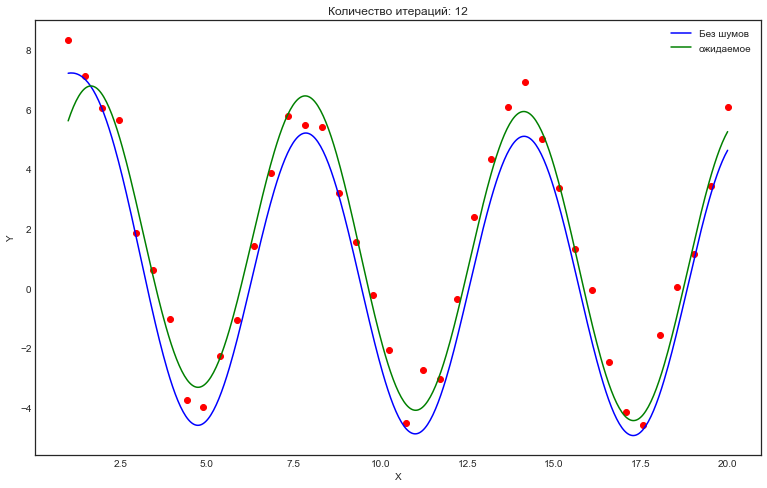

Запуск на функции     <function parabola at 0x7fa7289b5af0>
Действительный B:               [4 2]
Найденные коэфициенты:    [3.81232456 4.04343481]



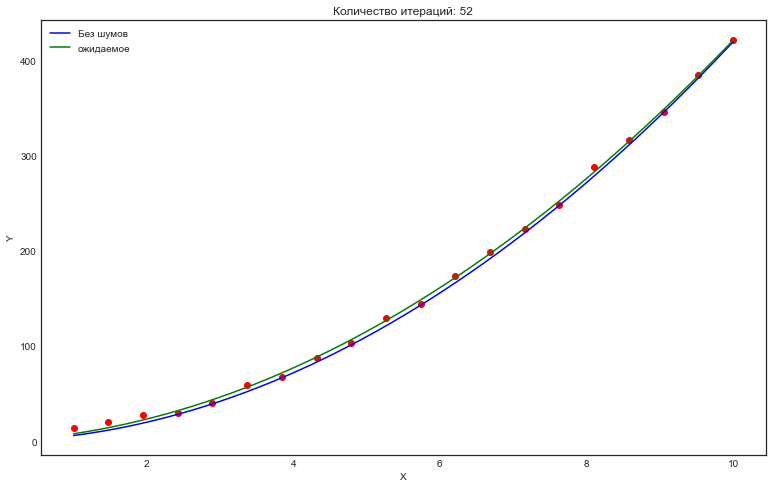

In [6]:
gauss_newton = GaussNewton(with_sinus, 1e-15, 1000)
gauss_newton.run(N=40, rand_coefficient = 2)
gauss_newton = GaussNewton(parabola, 1e-15, 1000)
gauss_newton.run(N=20, rand_coefficient = 10)

### Линейная регрессия

Запуск на функции     <function linear at 0x7fa7289b5b80>
Действительный B:               [2 5]
Найденные коэфициенты:    [5.42630976 4.84404903]



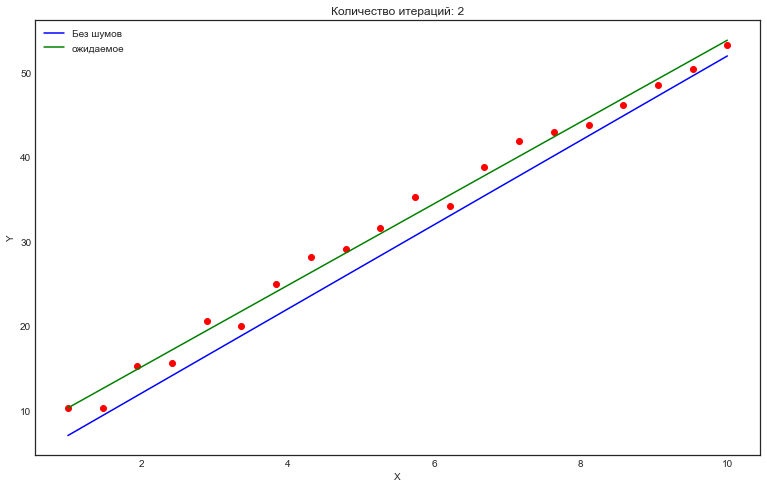

In [7]:
gauss_newton = GaussNewton(linear, 1e-15, 1000)
gauss_newton.run(N=20, rand_coefficient = 5)

## Powell's dogleg — реализация

In [8]:
class DogLeg(Nonlinear_regression_solver):
    def __init__(self, function, eps, max_iterations):
        super().__init__(function, eps, max_iterations)

    def func(self, B):
        return self.function(self.X, B)

    def fit(self, X, Y, B0):
        self.X = X
        self.Y = Y
        self.B = B0

        self.B, count_of_iterations = self.trust_region(B0)

        return self.B, count_of_iterations

    def grad(self, B0):
        J = self.jac(B0)
        r = self.r(B0)
        return 2 * (J.T @ r)

    def hess(self, B0):
        J = self.jac(B0)
        return 2 * (J.T @ J)

    def jac(self, B0, step=1e-6):
        Y0 = self.func(B0)
        J = []
        for i, parameter in enumerate(B0):
            B = B0.copy()
            B[i] += step
            Y = self.func(B)
            derivative = (Y - Y0) / step
            J.append(derivative)
        J = np.array(J).T
        return -J

    def r(self, B):
        return self.Y - self.func(B)

    @staticmethod
    def dogleg_method(Hk, gk, Bk, trust_radius):

        pB = -np.dot(Hk, gk)
        norm_pB = sqrt(np.dot(pB, pB))

        if norm_pB <= trust_radius:
            return pB

        pU = - (np.dot(gk, gk) / np.dot(gk, np.dot(Bk, gk))) * gk
        pU_squares = np.dot(pU, pU)
        norm_pU = sqrt(pU_squares)

        if norm_pU >= trust_radius:
            return trust_radius * pU / norm_pU

        pB_pU = pB - pU
        dot_pB_pU = np.dot(pB_pU, pB_pU)
        pU_squares_pB_pU = np.dot(pU, pB_pU)
        fact = pU_squares_pB_pU ** 2 - dot_pB_pU * (pU_squares - trust_radius ** 2)
        tau = (-pU_squares_pB_pU + sqrt(fact)) / dot_pB_pU

        return pU + tau * pB_pU

    def trust_region(self, x0, initial_trust_radius=1.0,
                            max_trust_radius=100.0, eta=0.15, gtol=1e-4,
                            maxiter=100):
        xk = x0
        trust_radius = initial_trust_radius
        count_of_iterations = 0
        while True:

            gk = self.grad(xk)
            Bk = self.hess(xk)
            Hk = np.linalg.inv(Bk)
            pk = self.dogleg_method(Hk, gk, Bk, trust_radius)
            act_red = np.sum(self.r(xk)**2) - np.sum(self.r(xk + pk)**2)
            pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))

            if pred_red == 0.0:
                rhok = 1e99
            else:
                rhok = act_red / pred_red

            norm_pk = sqrt(np.dot(pk, pk))

            if rhok < 0.25:
                trust_radius = 0.25 * norm_pk
            else:
                if rhok > 0.75 and norm_pk == trust_radius:
                    trust_radius = min(2.0 * trust_radius, max_trust_radius)
                else:
                    trust_radius = trust_radius

            if rhok > eta:
                xk = xk + pk
            else:
                xk = xk

            if ln.norm(gk) < gtol:
                break

            if count_of_iterations >= maxiter:
                break
            count_of_iterations = count_of_iterations + 1
        return xk, count_of_iterations

    def run(self, N = 30, rand_coefficient = 2):
        super().run(N, rand_coefficient)

## Powell's dogleg — запуск
### Нелинейная регрессия

Запуск на функции     <function with_sinus at 0x7fa7289b5a60>
Действительный B:               [4 5]
Найденные коэфициенты:    [ 4.26542715 19.18027929]



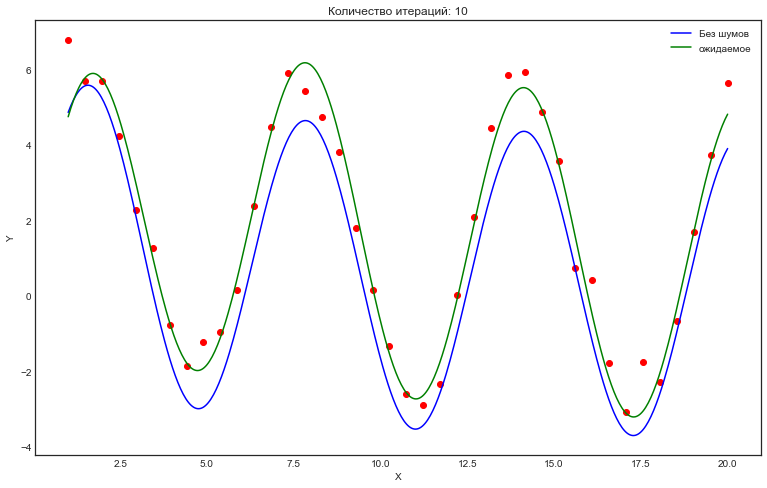

Запуск на функции     <function parabola at 0x7fa7289b5af0>
Действительный B:               [5 4]
Найденные коэфициенты:    [4.8375268  5.85713138]



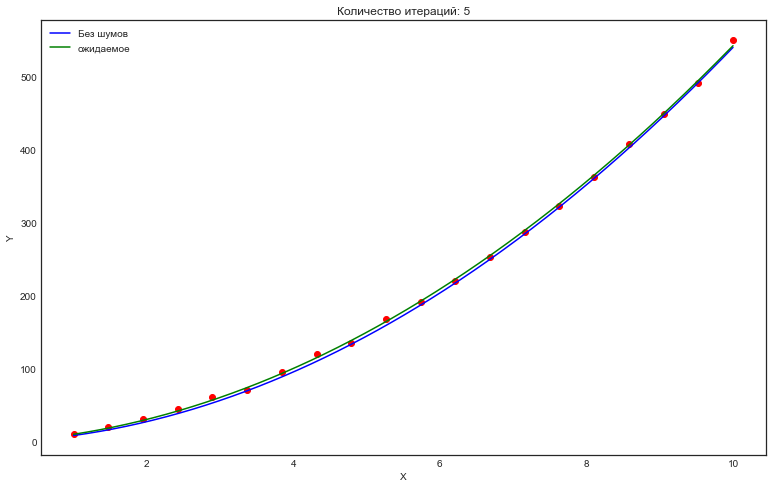

In [9]:
dog_leg = DogLeg(with_sinus, 1e-15, 1000)
dog_leg.run(N=40, rand_coefficient = 2)
dog_leg = DogLeg(parabola, 1e-15, 1000)
dog_leg.run(N=20, rand_coefficient = 10)

### Линейная регрессия

Запуск на функции     <function linear at 0x7fa7289b5b80>
Действительный B:               [5 5]
Найденные коэфициенты:    [7.59728722 5.0373603 ]



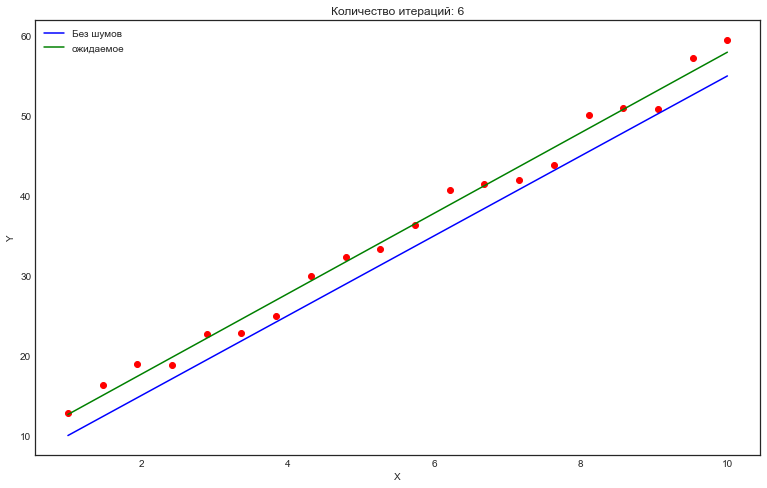

In [10]:
dog_leg = DogLeg(linear, 1e-15, 1000)
dog_leg.run(N=20, rand_coefficient = 5)

# Задание 2-3
## BFGS и L-BFGS - реализация

In [11]:
class BFGS:
    def __init__(self, func, grad, eps, max_iterations):
        self.func = func
        self.grad = grad
        self.eps = eps
        self.max_iterations = max_iterations

    def wolfe_condition(self, x, a, p, c1=1e-4, c2=0.9):
        grad_x = self.grad(x)
        cond1 = self.func(x + a * p) <= self.func(x) + c1 * a * np.dot(grad_x, p)
        cond2 = np.dot(self.grad(x + a * p), p) >= c2 * np.dot(grad_x, p)
        return cond1 and cond2

    def dichotomy(self, x, p):
        def phi(alpha):
            return self.func(x + alpha * p)

        a1 = 0.5
        while phi(a1) >= phi(0):
            a1 /= 2
        a2 = 1
        while phi(a1) >= phi(a2):
            a2 *= 2
        a, b = 0, a2
        while not self.wolfe_condition(x, a, p):
            a1 = a + (b - a) / 3
            b1 = a + (b - a) / 3 * 2
            if phi(a1) < phi(b1):
                b = b1
            else:
                a = a1
        return x + a * p

    def paint(self, point_of_descent, min_value, max_value, total_number):
        fig = plt.figure()
        fig.set_size_inches(10, 10)
        ax = plt.axes(projection='3d')
        x = np.linspace(min_value, max_value, total_number)
        y = np.linspace(min_value, max_value, total_number)
        x, y = np.meshgrid(x, y)
        z = self.func([x, y])
        ax.plot_surface(x, y, z, cmap='coolwarm', alpha=0.7)
        xD, yD = [], []
        for xi, yi in point_of_descent:
            xD.append(xi)
            yD.append(yi)
        xD = np.array(xD)
        yD = np.array(yD)
        zD = self.func([xD, yD])

        for i in range(1, len(xD)):
            ax.plot([xD[i], xD[i - 1]], [yD[i], yD[i - 1]], zs=[zD[i], zD[i - 1]], color='red')
        ax.scatter(xD[0], yD[0], zD[0], linewidths=3, color='red')
        ax.scatter(xD[len(xD) - 1], yD[len(yD) - 1], zD[len(zD) - 1], linewidths=3, color='red')
        plt.show()


    def run(self, x0, count):
        pass

In [12]:
class Classic_BFGS(BFGS):
    def __init__(self, func, grad, eps, max_iterations):
        super().__init__(func, grad, eps, max_iterations)

    def run(self, x0, beta):
        points = [x0]
        grads = [self.grad(x0)]
        I = np.diag(np.ones(x0.shape))
        H = beta * I
        for k in range(self.max_iterations):
            x = points[k]
            grad = grads[k]

            p = -np.matmul(H, np.transpose(grad))

            new_x = self.dichotomy(x, p)
            new_grad = self.grad(new_x)
            points.append(new_x)
            grads.append(new_grad)

            s = new_x - x
            y = new_grad - grad
            ro = 1 / np.matmul(y, np.transpose(s))

            H = ro * np.matmul(np.transpose(s), s) + np.matmul(
                I - ro * np.matmul(np.transpose(s), y),
                np.matmul(
                    H,
                    I - ro * np.matmul(np.transpose(y), s)
                )
            )
            d = points[-2] - points[-1]
            if np.dot(d, d) <= self.eps ** 2:
                break
        return points

In [13]:
class L_BFGS(BFGS):
    def __init__(self, func, grad, eps, max_iterations):
        super().__init__(func, grad, eps, max_iterations)

    def run(self, x0, m):
        s = collections.deque()
        y = collections.deque()
        points = [x0]
        grads = [self.grad(x0)]
        for epoch in range(1, self.max_iterations + 1):
            x = points[-1]
            g = grads[-1]
            q = g
            ro = [1 / np.matmul(y[i], np.transpose(s[i])) for i in range(0, len(s))]
            a_deque = collections.deque()
            for i in range(len(s) - 1, -1, -1):
                a = ro[i] * np.matmul(s[i], np.transpose(q))
                q = q - a * y[i]
                a_deque.appendleft(a)
            if len(s) > 0:
                gamma = np.matmul(s[-1], np.transpose(y[-1])) / np.matmul(y[-1], np.transpose(y[-1]))
            else:
                gamma = 1e-3
            r = gamma * q
            for i in range(0, len(s)):
                a = a_deque[i]
                b = ro[i] * np.matmul(y[i], np.transpose(r))
                r = r + s[i] * (a - b)
            new_x = self.dichotomy(x, -r)
            new_g = self.grad(new_x)
            points.append(new_x)
            grads.append(new_g)
            s.append(new_x - x)
            y.append(new_g - g)
            if len(s) > m:
                s.popleft()
                y.popleft()
            d = points[-2] - points[-1]
            if np.dot(d, d) <= self.eps ** 2:
                break
        return points

## BFGS - запуск

In [14]:
def f(x):
    return (0.5 * x[0] - 3) ** 2 + (1.5 * x[1] + 1) ** 4

def f1(x):
    return np.array([(0.5 * x[0] - 3), 6 * (1.5 * x[1] + 1) ** 3])

min_value = -10
max_value = 10
total_number = 100

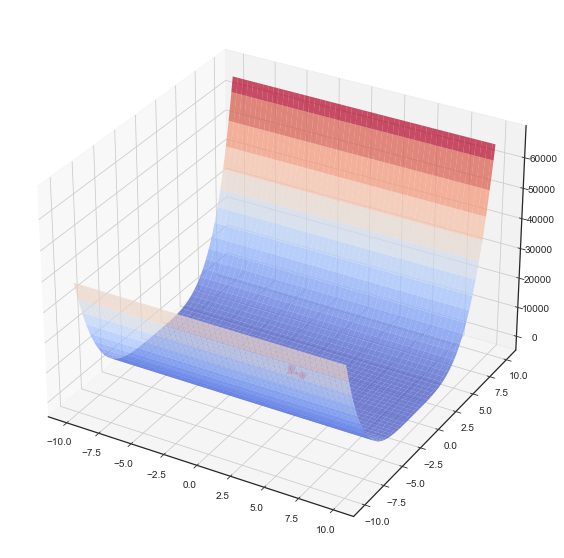

In [15]:
classic_bfgs_solver = Classic_BFGS(f, f1, eps=1e-6, max_iterations=500)
X0 = np.array([0.23435, 0.26343])
points = classic_bfgs_solver.run(X0, 1e-3)
classic_bfgs_solver.paint(points, min_value, max_value, total_number)

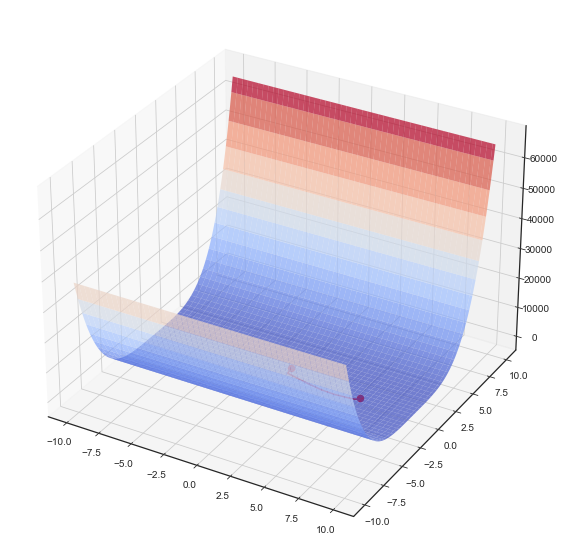

In [16]:
l_bfgs_solver = L_BFGS(f, f1, eps=1e-6, max_iterations=500)
X0 = np.array([0.23435, 0.26343])
points = l_bfgs_solver.run(X0, 5)
l_bfgs_solver.paint(points, min_value, max_value, total_number)